# Breast Cancer Survival Prediction 


In [384]:
# Check current working directory
import sys
print(sys.executable)

/anaconda/envs/azureml_py38/bin/python


#### **Importing necessary libraries**

In [385]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

#### **Access the dataset from the data blob storage**

In [394]:
import mltable
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

# Get a copy of credentials to authenticate the request of the dataset
ml_client = MLClient.from_config(credential=DefaultAzureCredential())
data_asset = ml_client.data.get("Breast-cancer-dataset", version="1")

tbl = mltable.load(f'azureml:/{data_asset.id}')

data = tbl.to_pandas_dataframe()

# make a copy of the dataset
df = data.copy()
df.head()

Found the config file in: /config.json


,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,None,0,claudin-low,1.0,Positve,...,0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0


### **Data preprocessing**

#### **Handling Missing Values**
- Checked for missing values in the dataset.
- For numeric columns, missing values were filled with the column mean.
- For categorical columns, missing values were filled with the mode of the column.
- This strategy ensures that we retain as much data as possible while handling missing values appropriately.

In [395]:
columns = df.columns
print (f'Number of columns: {len(columns)}')

Number of columns: 693


In [396]:
# checking for missing values in each colunm
df.isnull().sum()

patient_id                 0
age_at_diagnosis           0
type_of_breast_surgery    22
cancer_type                0
cancer_type_detailed      15
                          ..
hras_mut                   2
prps2_mut                  0
smarcb1_mut                2
stmn2_mut                  2
siah1_mut                  1
Length: 693, dtype: int64

In [397]:
# checking the shape of dataset before any preprocessing is done 
shape = df.shape
print(f'Number of rows: {shape[0]} \nNumber of Columns: {shape[1]}')

Number of rows: 1904 
Number of Columns: 693


In [398]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Handle missing values by filling with mean for numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# For categorical columns, fill missing values with the mode
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

# Verify if missing values are handled
print(df.isnull().sum().sum())  # Should output 0 if all missing values are handled


type_of_breast_surgery       22
cancer_type_detailed         15
cellularity                  54
er_status_measured_by_ihc    30
neoplasm_histologic_grade    72
                             ..
nras_mut                      3
hras_mut                      2
smarcb1_mut                   2
stmn2_mut                     2
siah1_mut                     1
Length: 63, dtype: int64
0


In [399]:
print(f'Missing data was handled without losing any rows as approved by the shape of the dataframe ')
shape2 = df.shape
print(f'Number of rows: {shape2[0]} \nNumber of Columns: {shape2[1]}')

Missing data was handled without losing any rows as approved by the shape of the dataframe 
Number of rows: 1904 
Number of Columns: 693


**Exploring   Gene Expression Data and mutation data using the genetic attributes** 

In [400]:
df.iloc[:,32:].describe()

,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,stk11,...,nr2f1_mut,klrg1_mut,mbl2_mut,ppp2cb_mut,smarcd1_mut,nras_mut,hras_mut,smarcb1_mut,stmn2_mut,siah1_mut
count,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1904.000000,1.904000e+03,1.904000e+03,1904.000000,1.904000e+03,...,1904.0,1904.0,1904.0,1904.0,1904.0,1904.0,1904.0,1904.0,1904.0,1904.0
mean,-4.201681e-07,3.676471e-07,-8.928571e-07,6.302521e-07,-2.100840e-07,0.000002,-7.463684e-18,-3.676471e-07,-0.000001,-4.726891e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,1.000262e+00,1.000263e+00,1.000263e+00,1.000263e+00,1.000262e+00,1.000263,1.000262e+00,1.000263e+00,1.000262,1.000263e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,-2.783500e+00,-4.384600e+00,-5.932800e+00,-2.481200e+00,-3.170500e+00,-3.323700,-2.688700e+00,-3.689800e+00,-2.968600,-3.060200e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,-6.994750e-01,-6.798250e-01,-5.586500e-01,-6.661500e-01,-6.602250e-01,-0.458600,-7.385500e-01,-6.667750e-01,-0.683925,-6.838250e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,-5.820000e-02,-2.210000e-02,1.098500e-01,-3.010000e-02,-4.200000e-03,0.115550,-1.311000e-01,-1.445000e-02,-0.054800,-5.785000e-02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,6.290000e-01,6.400000e-01,6.426250e-01,6.447500e-01,6.901500e-01,0.649800,5.431250e-01,6.387250e-01,0.668925,5.362750e-01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,3.737900e+00,4.615000e+00,3.254100e+00,4.289800e+00,3.824200e+00,2.820900,4.538200e+00,5.371300e+00,6.178600,4.850100e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [401]:
df.iloc[:,:31].describe()

,patient_id,age_at_diagnosis,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,overall_survival,radio_therapy,tumor_size,tumor_stage
count,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000,1904.000000
mean,3921.982143,61.087054,0.207983,2.643908,2.415939,0.616597,2.002101,5.697687,4.033019,125.121324,0.420693,0.597164,26.238726,1.750535
std,2358.478332,12.978711,0.405971,1.228615,0.638185,0.486343,4.079993,4.010503,1.144492,76.334148,0.493800,0.490597,15.081097,0.539889
min,0.000000,21.930000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,896.500000,51.375000,0.000000,1.000000,2.000000,0.000000,0.000000,3.000000,3.046000,60.825000,0.000000,0.000000,17.000000,1.000000
50%,4730.500000,61.770000,0.000000,3.000000,2.415939,1.000000,0.000000,5.000000,4.042000,115.616667,0.000000,1.000000,23.000000,1.750535
75%,5536.250000,70.592500,0.000000,3.000000,3.000000,1.000000,2.000000,7.000000,5.040250,184.716667,1.000000,1.000000,30.000000,2.000000
max,7299.000000,96.290000,1.000000,5.000000,3.000000,1.000000,45.000000,80.000000,6.360000,355.200000,1.000000,1.000000,182.000000,4.000000


### **EDA**

#### Clinical data EDA

In [402]:
clinical_data = df.iloc[:,:31]
clinical_data.head()

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,nottingham_prognostic_index,oncotree_code,overall_survival_months,overall_survival,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,tumor_stage,death_from_cancer
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,claudin-low,1.0,Positve,...,6.044,IDC,140.500000,1,Negative,1,ER-/HER2-,22.0,2.0,Living
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,4.020,IDC,84.633333,1,Positive,1,ER+/HER2- High Prolif,10.0,1.0,Living
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,4.030,IDC,163.700000,0,Positive,0,ER+/HER2- Low Prolif,15.0,2.0,Died of Disease
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,4.050,MDLC,164.933333,1,Positive,1,ER+/HER2- Low Prolif,25.0,2.0,Living
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,6.080,MDLC,41.366667,0,Positive,1,ER+/HER2- High Prolif,40.0,2.0,Died of Disease


In [403]:
clinical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   patient_id                      1904 non-null   int64  
 1   age_at_diagnosis                1904 non-null   float64
 2   type_of_breast_surgery          1904 non-null   object 
 3   cancer_type                     1904 non-null   object 
 4   cancer_type_detailed            1904 non-null   object 
 5   cellularity                     1904 non-null   object 
 6   chemotherapy                    1904 non-null   int64  
 7   pam50_+_claudin-low_subtype     1904 non-null   object 
 8   cohort                          1904 non-null   float64
 9   er_status_measured_by_ihc       1904 non-null   object 
 10  er_status                       1904 non-null   object 
 11  neoplasm_histologic_grade       1904 non-null   float64
 12  her2_status_measured_by_snp6    19

Handling categorical columns by first of all indentifying them and knowing the different Unique values each conatains 

In [404]:
# obtain columns that are not numeric rather they are of type object
str_cols = clinical_data.select_dtypes(include=['object']).columns
str_cols

# print total columns that of type object
print('Total string columns:',len(str_cols))

# printing the different unique values of each object columns 
for col in str_cols:
    print('-'*60)
    print('Column name:',col,'\n\n',clinical_data[col].unique())

Total string columns: 17
------------------------------------------------------------
Column name: type_of_breast_surgery 

 ['MASTECTOMY' 'BREAST CONSERVING']
------------------------------------------------------------
Column name: cancer_type 

 ['Breast Cancer' 'Breast Sarcoma']
------------------------------------------------------------
Column name: cancer_type_detailed 

 ['Breast Invasive Ductal Carcinoma'
 'Breast Mixed Ductal and Lobular Carcinoma'
 'Breast Invasive Lobular Carcinoma'
 'Breast Invasive Mixed Mucinous Carcinoma' 'Breast'
 'Metaplastic Breast Cancer']
------------------------------------------------------------
Column name: cellularity 

 ['High' 'Moderate' 'Low']
------------------------------------------------------------
Column name: pam50_+_claudin-low_subtype 

 ['claudin-low' 'LumA' 'LumB' 'Her2' 'Normal' 'Basal' 'NC']
------------------------------------------------------------
Column name: er_status_measured_by_ihc 

 ['Positve' 'Negative']
------------

Change these categorical columns to numerical columns specifically by using label encoding.
This is because this will help us define the correlation of each of the columns with the target column 

In [405]:
# label encode all the columns that are not ints or floats 
from sklearn.preprocessing import LabelEncoder


# Dictionary to store the label encoders for each column
label_encoders = {}

# Apply LabelEncoder to each categorical column
for col in str_cols[:-1]:
    le = LabelEncoder()
    clinical_data[col] = le.fit_transform(clinical_data[col])
    label_encoders[col] = le

# Display the transformed dataframe
clinical_data.head()


,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,nottingham_prognostic_index,oncotree_code,overall_survival_months,overall_survival,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,tumor_stage,death_from_cancer
0,0,75.65,1,0,1,0,0,6,1.0,1,...,6.044,1,140.500000,1,0,1,2,22.0,2.0,Living
1,2,43.19,0,0,1,0,0,2,1.0,1,...,4.020,1,84.633333,1,1,1,0,10.0,1.0,Living
2,5,48.87,1,0,1,0,1,3,1.0,1,...,4.030,1,163.700000,0,1,0,1,15.0,2.0,Died of Disease
3,6,47.68,1,0,4,2,1,3,1.0,1,...,4.050,5,164.933333,1,1,1,1,25.0,2.0,Living
4,8,76.97,1,0,4,0,1,3,1.0,1,...,6.080,5,41.366667,0,1,1,0,40.0,2.0,Died of Disease


In [406]:
# change the target column to yes or no ie 1 or 0 
clinical_data.iloc[:,-1] = clinical_data.iloc[:,-1].map({'Living':0,'Died of Disease':1,'Died of Other Causes':0})

In [407]:
# comfirming that the target column only contains 0 and 1 
clinical_data.death_from_cancer.unique()

array([0, 1], dtype=object)

In [408]:
clinical_data['cancer_type'].dtype

dtype('int64')

In [409]:
clinical_data.shape

(1904, 31)

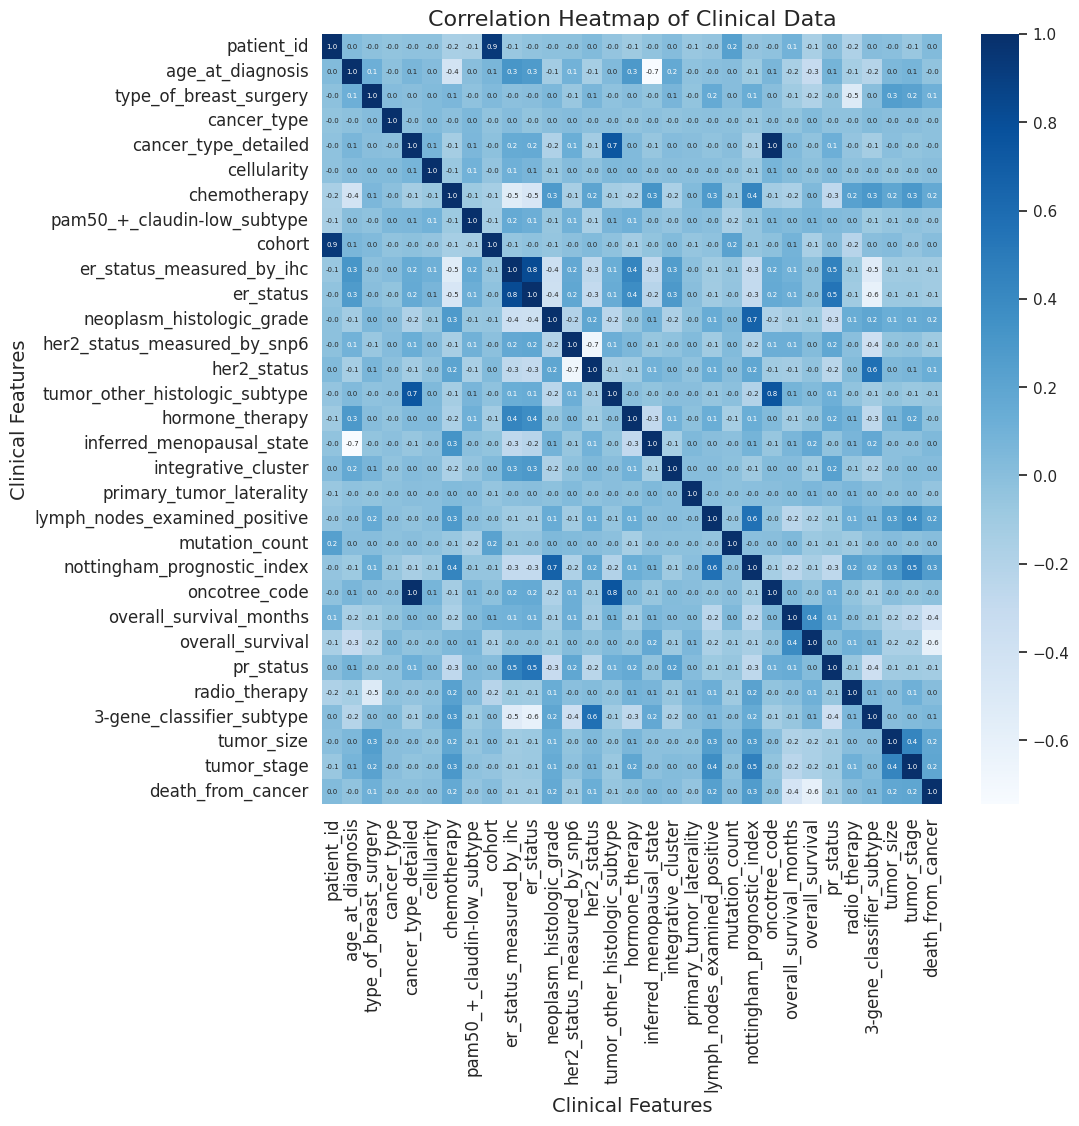

In [413]:
# get correlation of the data to see its effect on the target variable
clinical_data_corr = clinical_data.corr()

# plot a heatmap
sns.set_theme()
plt.figure(figsize=(10,10))
sns.heatmap(clinical_data_corr,cmap ='Blues',annot=True,fmt=".1f",annot_kws={"size": 5})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Correlation Heatmap of Clinical Data', fontsize=16)
plt.xlabel('Clinical Features', fontsize=14)
plt.ylabel('Clinical Features', fontsize=14)
plt.savefig('Correlation Heatmap of Clinical Data heatmap.pdf')
plt.show()

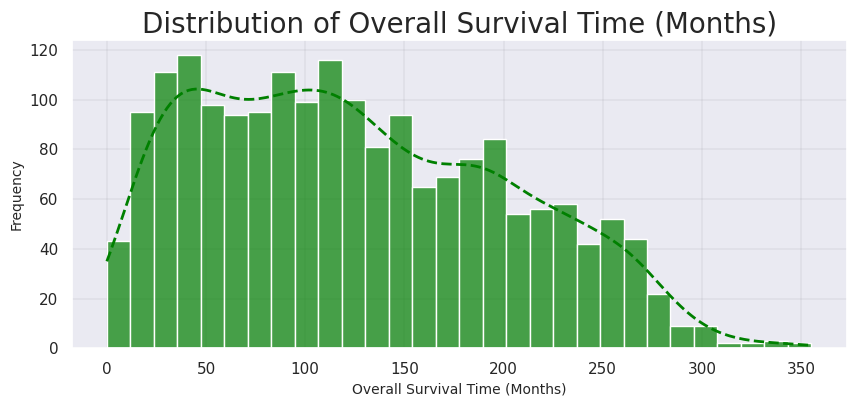

In [415]:
# Distribution of Overall Survival Time (Months)
plt.figure(figsize=(10, 4))

# Plot the histogram with KDE
sns.histplot(df['overall_survival_months'], kde=True, color="green", bins=30, alpha=0.7, line_kws={'linestyle':'--', 'linewidth':2, 'color':'darkred'})
plt.title('Distribution of Overall Survival Time (Months)', fontsize=20)
plt.xlabel('Overall Survival Time (Months)', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.savefig('Distribution of Overall Survival Time (Months).pdf')
plt.show()

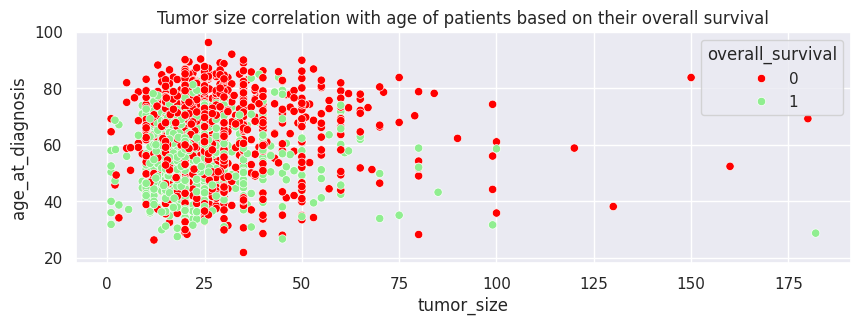

In [416]:
plt.figure(figsize=(10,3))
sns.scatterplot(x = clinical_data['tumor_size'], y = clinical_data['age_at_diagnosis'], hue = df['overall_survival'],palette={1: 'lightgreen', 0: 'red'})
plt.title('Tumor size correlation with age of patients based on their overall survival')
plt.savefig('Tumor size correlation with age of patients based on their overall survival.pdf')
plt.show()


EDA for genes and mutations 


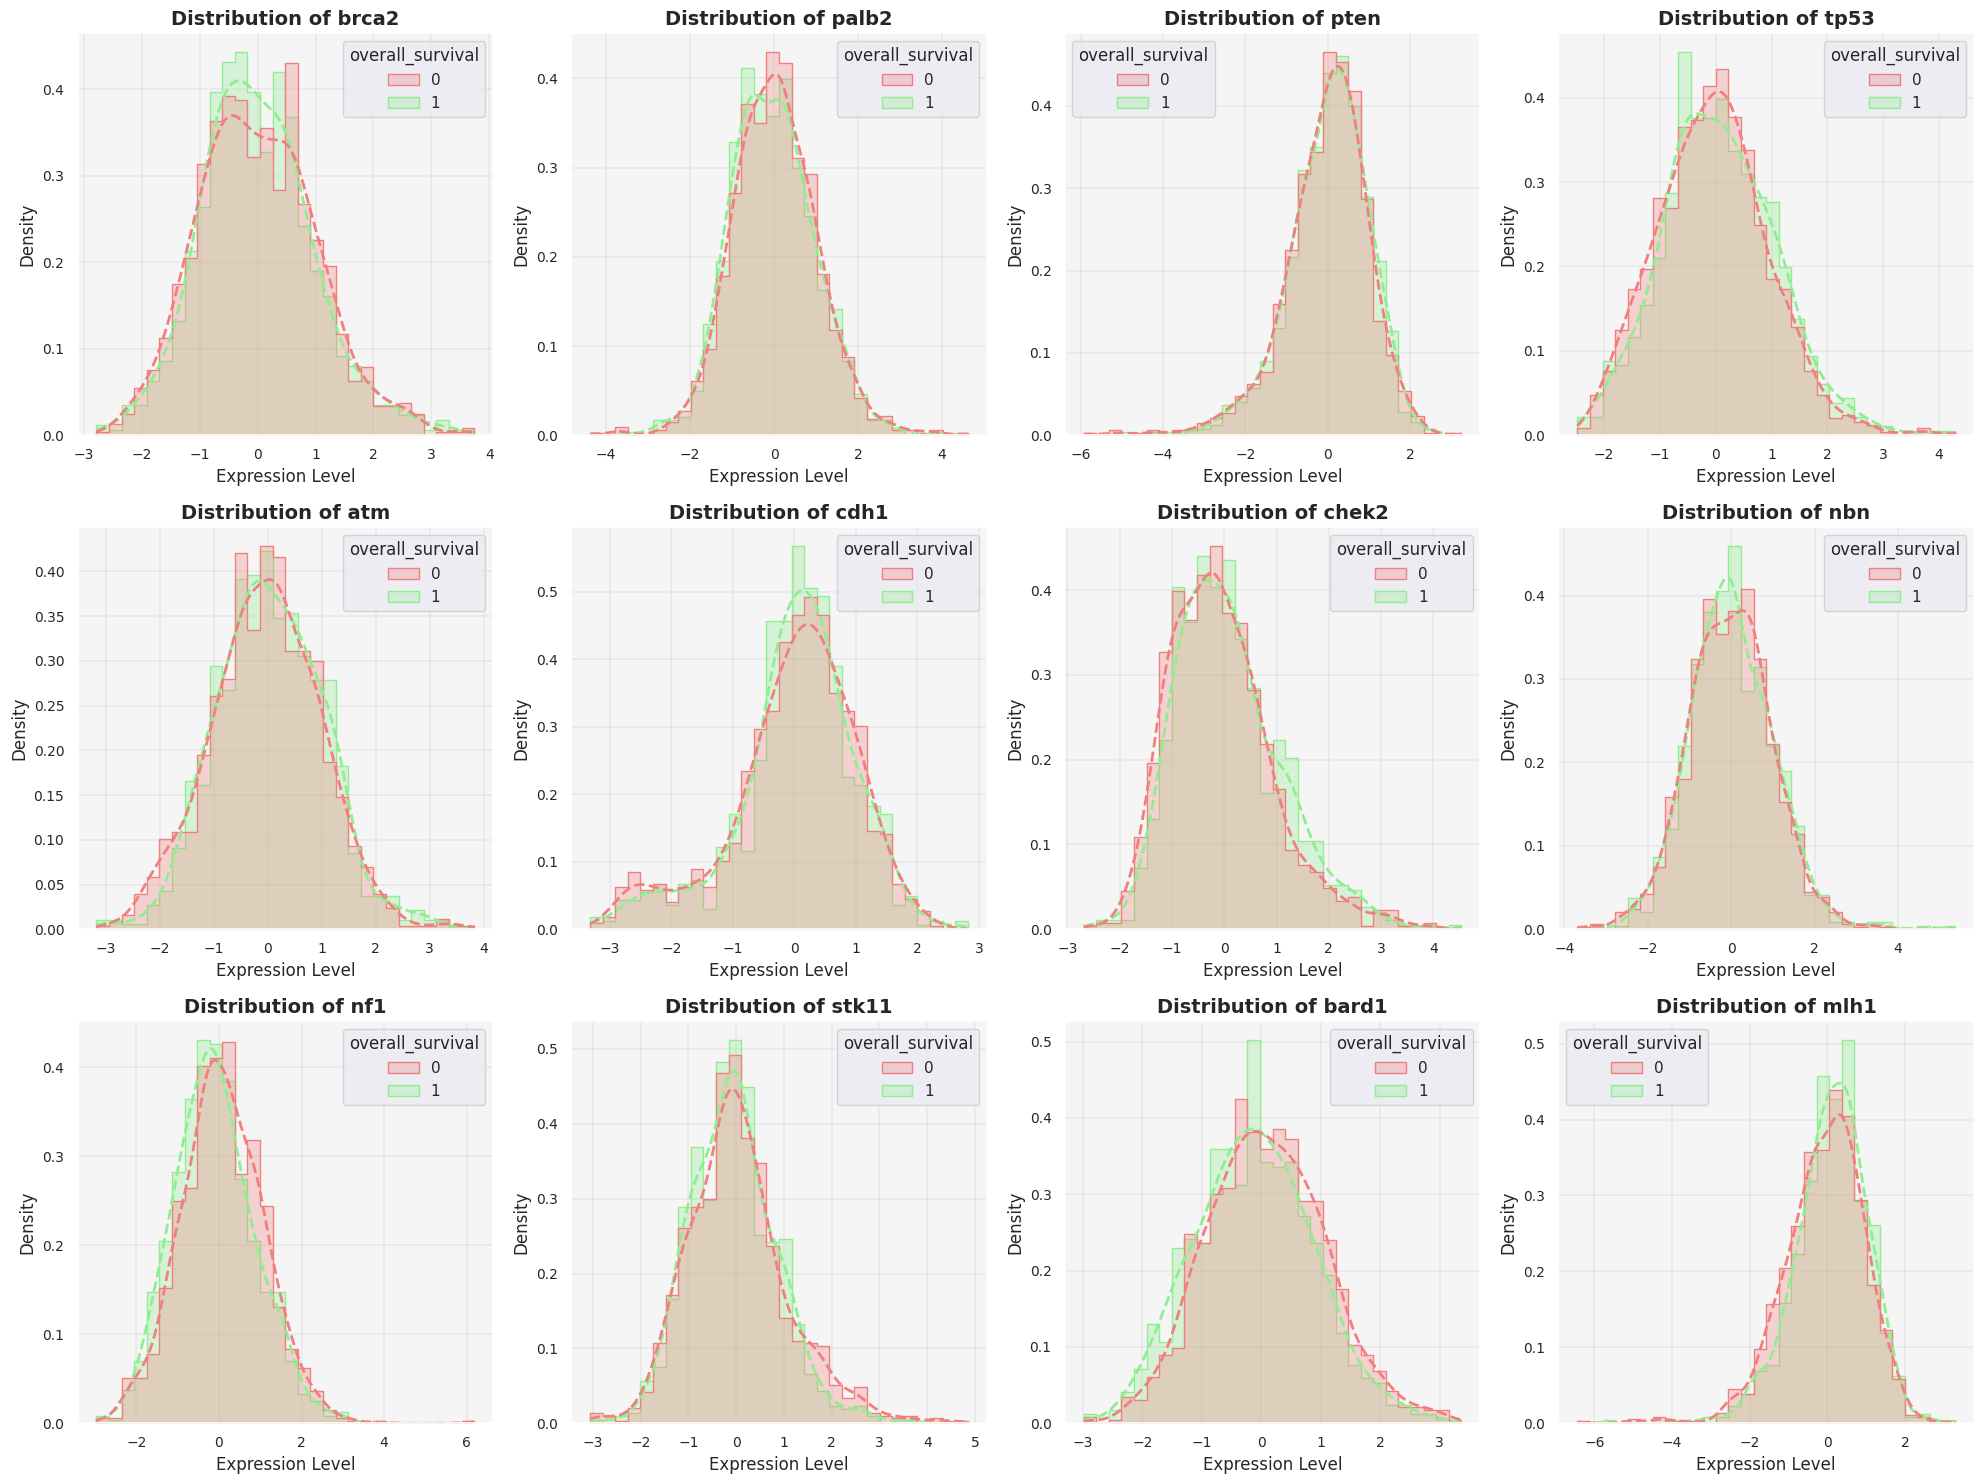

In [418]:
# Assuming 'df' is your DataFrame and columns 32 to 44 are the gene expression levels
genes_to_visualize = df.iloc[:, 32:44].columns

# Plot the distribution of gene expression levels for selected genes
plt.figure(figsize=(20, 15))
for i, gene in enumerate(genes_to_visualize, 1):
    plt.subplot(3, 4, i)
    sns.histplot(df, x=gene, hue="overall_survival", kde=True, bins=30, 
                 palette={1: "lightgreen", 0: "lightcoral"}, alpha=0.3, 
                 element="step", stat="density", common_norm=False, 
                 line_kws={'linestyle': '--', 'linewidth': 2})
    plt.title(f'Distribution of {gene}', fontsize=14, weight='bold')
    plt.xlabel('Expression Level', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    plt.gca().set_facecolor('whitesmoke')
    plt.savefig('sample_gene_distribution varied with survival outcome.pdf')

plt.tight_layout()
plt.show()


From the viz above, we can can now say that most of the gene expression have no significant effect on our target column which is the overall survival

###  Correlations between gene expression and overall survival

jak1      0.194412
gsk3b     0.186323
kmt2c     0.171925
casp8     0.168368
tgfbr2    0.166388
map4      0.165276
abcb1     0.164657
kit       0.164288
tsc2      0.161890
pdgfra    0.159744
dtype: float64


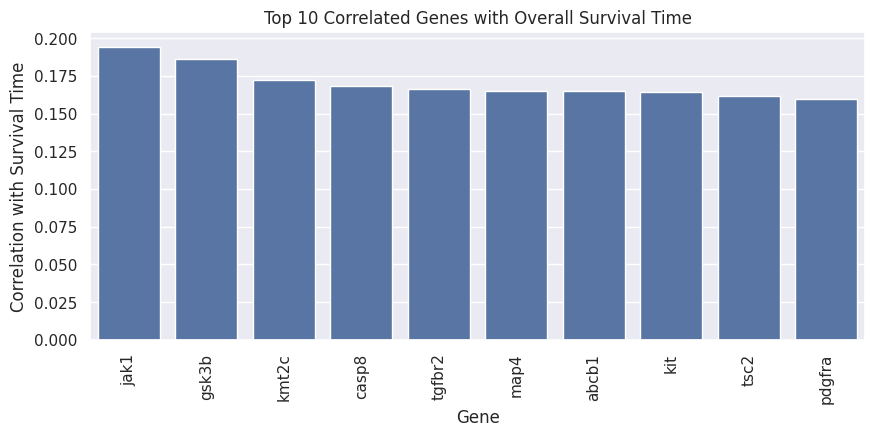

In [422]:
# Calculate correlations between gene expression and overall survival
gene_expression_df = df.iloc[:,32:362]
correlations = gene_expression_df.corrwith(df['overall_survival'])

# Display the top correlated genes
top_correlated_genes = correlations.abs().sort_values(ascending=False).head(10)
print(top_correlated_genes)

# Plot the correlations of the top genes
plt.figure(figsize=(10, 4))
sns.barplot(x=top_correlated_genes.index, y=top_correlated_genes.values)
plt.title('Top 10 Correlated Genes with Overall Survival Time')
plt.xlabel('Gene')
plt.ylabel('Correlation with Survival Time')
plt.xticks(rotation=90)
plt.savefig('Top 10 Correlated Genes with Overall Survival Time.pdf')
plt.show()

['jak1' 'kit' 'stat5a' 'runx1' 'gsk3b']
       Gene  Importance
46     jak1    0.026236
181     kit    0.012281
51   stat5a    0.010490
287   runx1    0.008721
168   gsk3b    0.008583
102    hes2    0.008191
276  arid1a    0.007487
139   casp8    0.007265
319  arid5b    0.007169
300    map4    0.006859


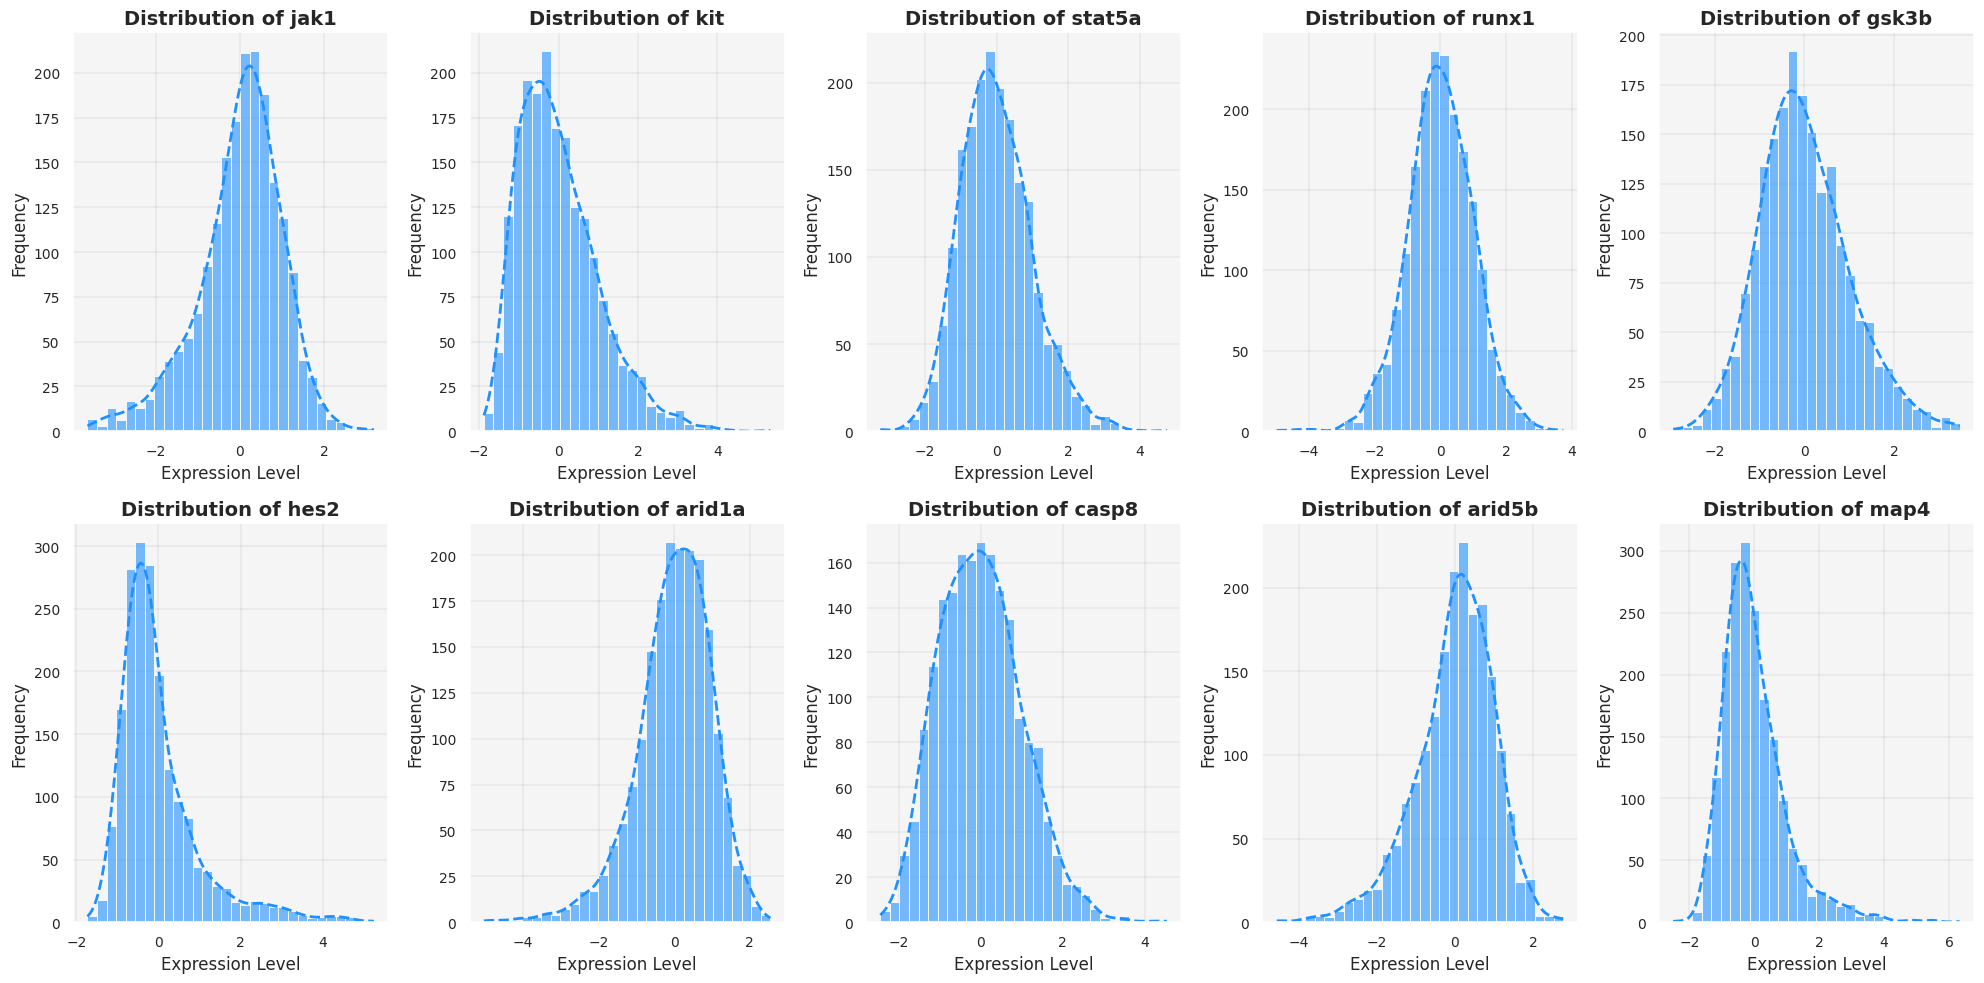

/tmp/ipykernel_8458/3816031136.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='overall_survival', y=gene, data=df, palette={'1': 'lightgreen', '0': 'lightcoral'})
/tmp/ipykernel_8458/3816031136.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='overall_survival', y=gene, data=df, palette={'1': 'lightgreen', '0': 'lightcoral'})
/tmp/ipykernel_8458/3816031136.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='overall_survival', y=gene, data=df, palette={'1': 'lightgreen', '0': 'lightcoral'})
/tmp/ipykernel_8458/3816031136.py:

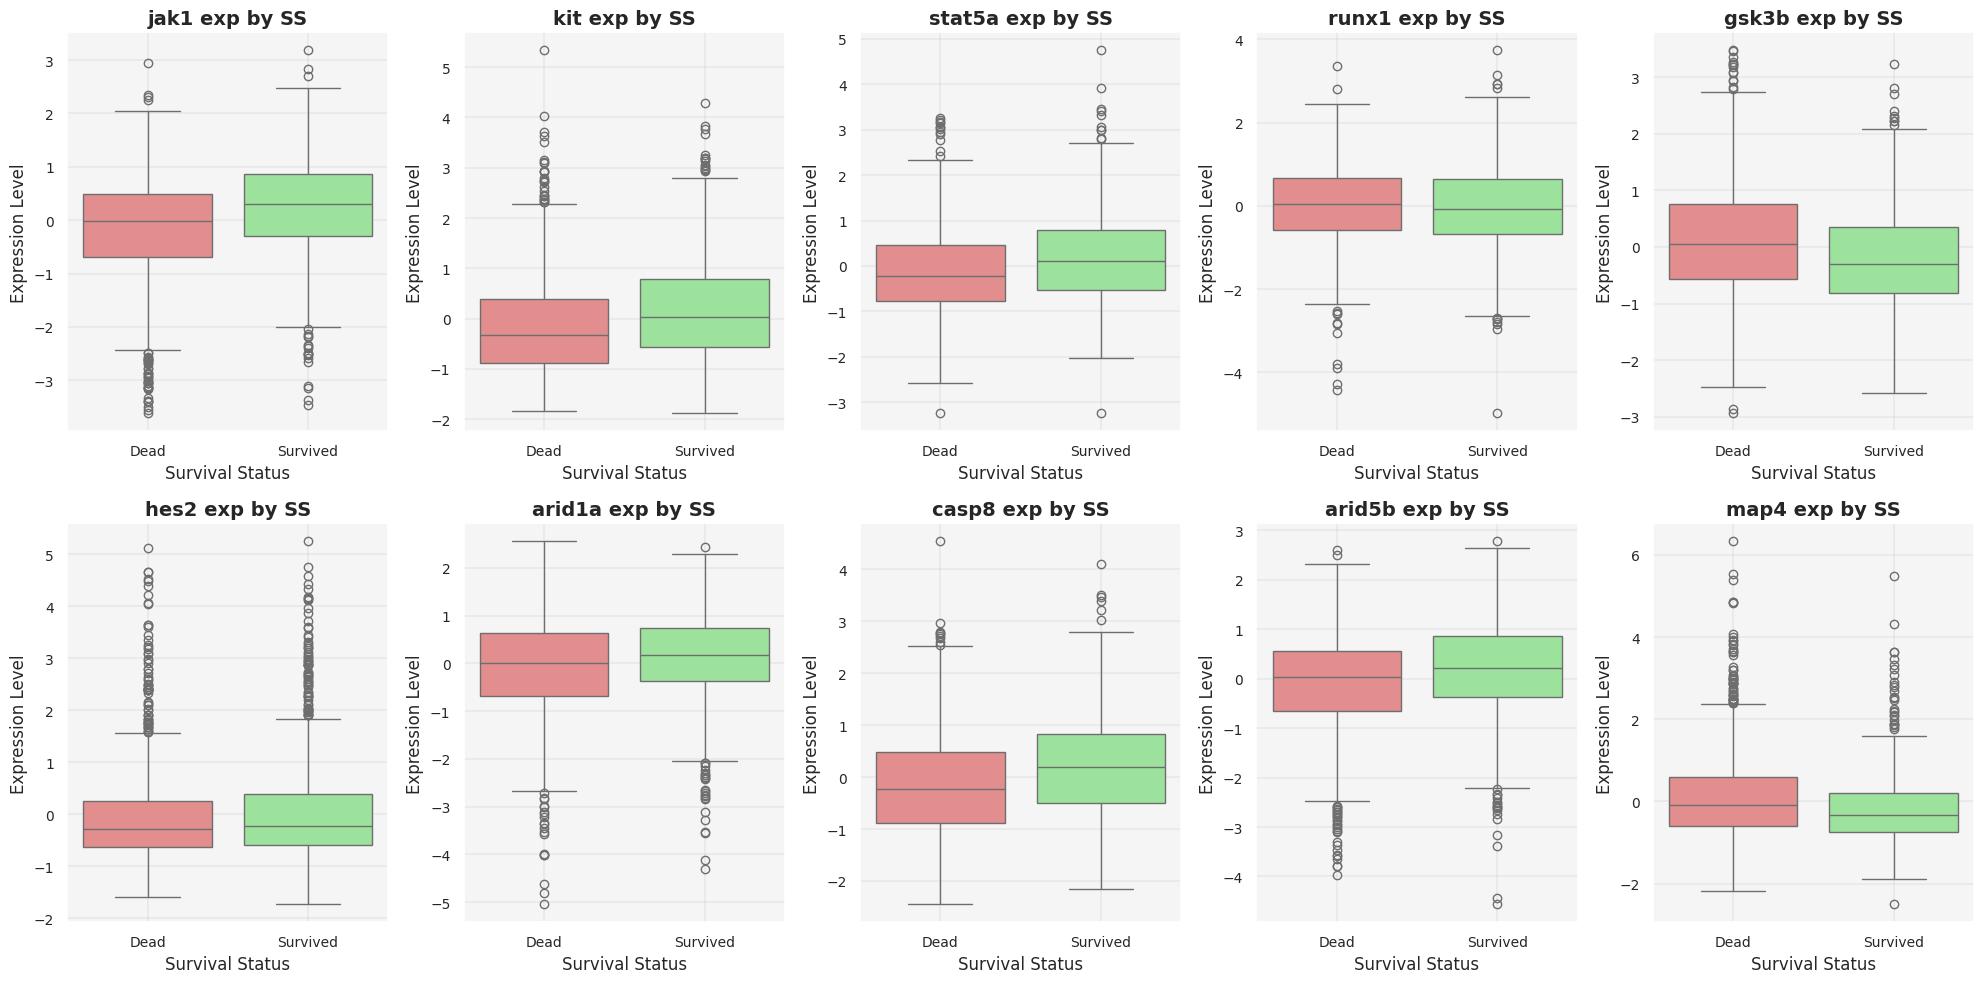

In [423]:
from sklearn.ensemble import RandomForestRegressor

# Assuming gene expression data is in columns 32 to 362
gene_expression_columns = df.columns[32:362]  # Adjust the range according to the actual columns of interest
X = df[gene_expression_columns]
y = df['overall_survival']

# Train a Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X, y)

# Get feature importance scores
importances = model.feature_importances_
importance_df = pd.DataFrame({'Gene': gene_expression_columns, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df.iloc[:5,0].values)
# Get the top 10 important genes
important_genes = importance_df['Gene'].head(10)
print(importance_df.head(10))

#Visualize Gene Expression Patterns
# Histogram with KDE for each important gene
plt.figure(figsize=(20, 10))
for i, gene in enumerate(important_genes, 1):
    plt.subplot(2, 5, i)
    sns.histplot(df[gene], kde=True, color="dodgerblue", bins=30, alpha=0.6, line_kws={'linestyle':'--', 'linewidth':2, 'color':'darkred'})
    plt.title(f'Distribution of {gene}', fontsize=14, weight='bold')
    plt.xlabel('Expression Level', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    plt.gca().set_facecolor('whitesmoke')
plt.tight_layout()
plt.savefig('RFR top 10 Correlated Genes with Overall Survival Time distribution.pdf')
plt.show()

# Boxplot with survival status
plt.figure(figsize=(20, 10))
for i, gene in enumerate(important_genes, 1):
    plt.subplot(2, 5, i)
    sns.boxplot(x='overall_survival', y=gene, data=df, palette={'1': 'lightgreen', '0': 'lightcoral'})
    plt.title(f'{gene} exp by SS', fontsize=14, weight='bold')
    plt.xlabel('Survival Status', fontsize=12)
    plt.ylabel('Expression Level', fontsize=12)
    plt.xticks(ticks=[0, 1], labels=['Dead', 'Survived'], fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    plt.gca().set_facecolor('whitesmoke')
plt.tight_layout()
plt.savefig('RFR top 10 Correlated Genes with Overall Survival Time box plot.pdf')
plt.show()

/tmp/ipykernel_8458/2013048541.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='overall_survival', y='age_at_diagnosis', data=df, palette={'1': 'lightgreen', '0': 'lightcoral'})


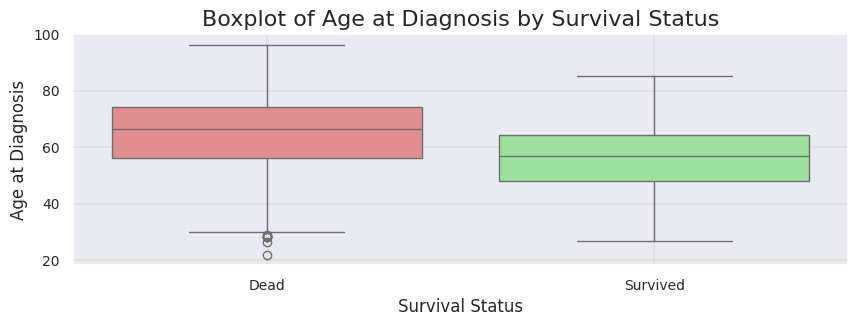

In [424]:
plt.figure(figsize=(10, 3))

# Plot the boxplot with hue
sns.boxplot(x='overall_survival', y='age_at_diagnosis', data=df, palette={'1': 'lightgreen', '0': 'lightcoral'})

# Set plot title and labels
plt.title('Boxplot of Age at Diagnosis by Survival Status', fontsize=16)
plt.xlabel('Survival Status', fontsize=12)
plt.ylabel('Age at Diagnosis', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Dead', 'Survived'], fontsize=10)
plt.yticks(fontsize=10)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.savefig('Age with Overall Survival Time box plot.pdf')
plt.show()


### **Feature selection**

In [425]:
import scipy.stats as stats

#Chi-square test for categorical variables
categorical_vars = str_cols[:-1]
sig_features = []
for var in categorical_vars:
    contingency_table = pd.crosstab(df[var], df['overall_survival'])
    chi2, p, dof, ex = stats.chi2_contingency(contingency_table)
    if p < 0.05:
        sig_features.append(var)

for feature in sig_features:
    print(feature)


type_of_breast_surgery
cancer_type_detailed
pam50_+_claudin-low_subtype
tumor_other_histologic_subtype
inferred_menopausal_state
integrative_cluster
primary_tumor_laterality
oncotree_code
3-gene_classifier_subtype


In [426]:
df.iloc[:,:31] = clinical_data.iloc[:,:]

In [428]:
df.shape

(1904, 693)

In [429]:
# Check for non-numeric columns
gene_data = df.iloc[:,31:]
gene_data_str_cls = gene_data.select_dtypes(include=['object']).columns
gene_data_str_cls

for col in gene_data_str_cls:
    print('-'*60)
    print('Column name:',col,'\n\n',gene_data[col].unique())

------------------------------------------------------------
Column name: pik3ca_mut 

 ['0' 'H1047R' 'E542K' 'Q546H G1049R' 'E545K' 'N345K E81K' 'H1047L E726K'
 'H1047L' 'E545Q' 'N345K' 'L452Kfs*4 E453Dfs*7' 'N345K N1044K'
 'E365K C420R' 'E545K H1047R' 'E542K E726K' 'E453_L455del' 'G451_D454del'
 'E110del' 'Q546K' 'H1047R E453K' 'R88Q' 'H1047R P104L' 'H1047R E726K'
 'M1043V' 'Q546P' 'N1068Kfs*5' 'H1047R R108H' 'K111E' 'H1047R G118D'
 'H1047R H1048R' 'E545G' 'E542K N345K' 'E545K G320A' 'E545K S509Y' 'E418K'
 'E545K G914R' 'H1047R L10_P17del' 'C420R' 'P449S' 'E545K E726K'
 'H1047R E81K' 'Q546R' 'H1047R D1029H H1048R' 'E545K M1043V' 'P449T'
 'V105del K148N' 'A1066Cfs*7' 'H1047R T727K' 'E545A' 'H1047R E80K' 'E726K'
 'H1047L E385K' 'H1047R K111E' 'E542K T727K' 'M1043I' 'H1047R P471L'
 'E726K P449_L452del' 'G118D' 'N345K M1043I' 'Y1021Hfs*9' 'P447_L455del'
 'Q546H' 'Q546R E453K' 'E542K Y1021H' 'R108del' 'M1043V E726K'
 'E545K D725N' 'H1047R E365K' '*1069Lfs*5' 'E453_G460delinsD' 'H1047Y'
 '

In [430]:
label_encoders_2 = {}

# Apply LabelEncoder to each categorical column
for col in gene_data_str_cls:
    le = LabelEncoder()
    gene_data[col] = le.fit_transform(gene_data[col])
    label_encoders_2[col] = le

# Display the transformed dataframe
gene_data.head()


,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,-1.3990,-0.5738,-1.6217,1.4524,0.3504,1.1517,0.0348,0.1266,-0.8361,-0.8578,...,0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
1,-1.3800,0.2777,-1.2154,0.5296,-0.0136,-0.2659,1.3594,0.7961,0.5419,-2.6059,...,0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
2,0.0670,-0.8426,0.2114,-0.3326,0.5141,-0.0803,1.1398,0.4187,-0.4030,-1.1305,...,0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
3,0.6744,-0.5428,-1.6592,0.6369,1.6708,-0.8880,1.2491,-1.1889,-0.4174,-0.6165,...,0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0
4,1.2932,-0.9039,-0.7219,0.2168,0.3484,0.3897,0.9131,0.9356,0.7675,-0.2940,...,0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0


In [431]:
gene_data.shape

(1904, 662)

In [432]:
for col in gene_data_str_cls:
    print('-'*60)
    print('Column name:',col,'\n\n',gene_data[col].unique())

------------------------------------------------------------
Column name: pik3ca_mut 

 [  1  65  17 137  30 119  62  59  45 117 110 122  12  39  19  16  58  10
 138  69 145  87  71 112 139 115  92 101  78  79  29  22  37  44  13  38
  85   4 130  36  75 141  66  42 131 151   3  94  26  73  46  61  83  24
 111  90  48  55 121 158 129 136 142  25 143 113  32  68   0  15  95  18
 147  99  51  63  53 124 133  20 104  54  89 120 107 144 134 114 118  14
  43  40  21 157 105  50 106 100  49  72  91 150 153 140 126  11  98  70
  60 102  47   6  97 109  81  80  33 155 108 123  31  41 159 128 103   9
  56 146  77  28 135 148   8  74 152  88  64  35  67  86  27  82  93   5
  52 149  84  23  96  34  57 156  76 127 132 125   7 116   2 154]
------------------------------------------------------------
Column name: tp53_mut 

 [  2 109 281 206  34  19 284 246  95 230 189  40 216 213 142 102 332 269
 122 259 224  87 323 119 232  94  46  20 237 297 304 137 254 174   6 334
 249 171 282 260 238 195 129 1

In [436]:
df_final = pd.concat([clinical_data,gene_data],axis = 1)


In [437]:
df_final.shape

(1904, 693)

In [438]:
df_final['overall_survival']

0       1
1       1
2       0
3       1
4       0
       ..
1899    1
1900    0
1901    0
1902    0
1903    0
Name: overall_survival, Length: 1904, dtype: int64

In [441]:
X = df_final.drop('overall_survival',axis = 1)
y = df_final['overall_survival']

                           feature  importance
29               death_from_cancer    0.068732
23         overall_survival_months    0.039599
1                 age_at_diagnosis    0.023838
0                       patient_id    0.006591
27                      tumor_size    0.006024
16       inferred_menopausal_state    0.005251
481                       hsd17b11    0.004947
467                         cdkn2c    0.004418
514                           tnk2    0.004248
19   lymph_nodes_examined_positive    0.004054
374                           flt3    0.004027
77                            jak1    0.003864
2           type_of_breast_surgery    0.003759
320                          abcb1    0.003421
170                          casp8    0.003266
508                          spry2    0.003257
21     nottingham_prognostic_index    0.003112
388                          lama2    0.003050
199                          gsk3b    0.003039
225                         mapk14    0.002992


/tmp/ipykernel_8458/243187587.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_df['importance'], y=feature_importance_df['feature'], palette=colors)
/tmp/ipykernel_8458/243187587.py:24: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x=feature_importance_df['importance'], y=feature_importance_df['feature'], palette=colors)


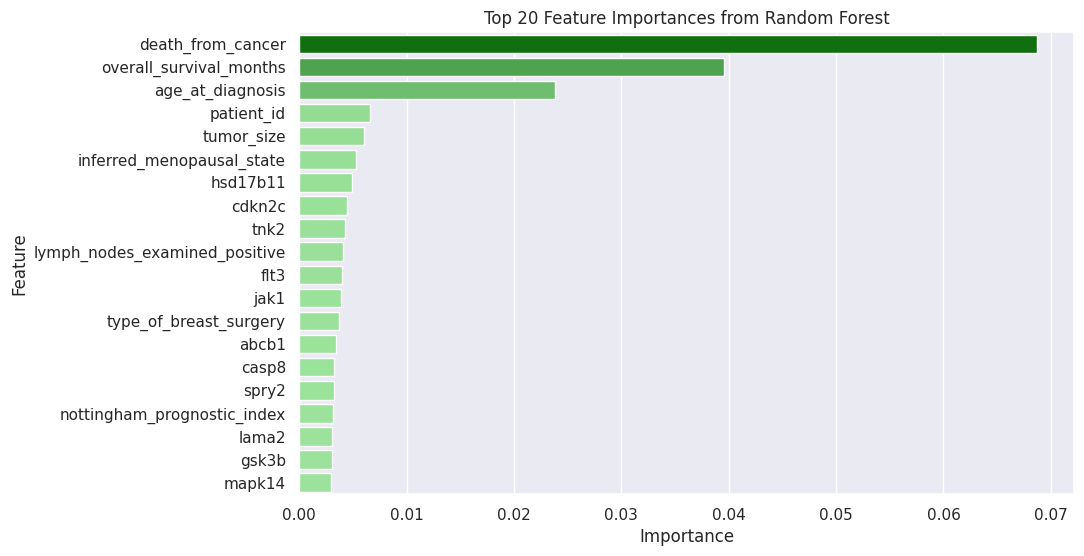

In [448]:
from sklearn.ensemble import RandomForestClassifier
from matplotlib.colors import LinearSegmentedColormap

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X, y)

# Get feature importances
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False).head(20)
print(feature_importance_df)

# Plot the feature importances
cmap = LinearSegmentedColormap.from_list("importance_cmap", ["lightgreen", "green"])

# Normalize the importance values to [0, 1] for mapping to the colormap
norm = plt.Normalize(feature_importance_df['importance'].min(), feature_importance_df['importance'].max())
colors = cmap(norm(feature_importance_df['importance']))

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_df['importance'], y=feature_importance_df['feature'], palette=colors)
plt.title('Top 20 Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.savefig('Top 20 Important features barplot.pdf')
plt.show()